In [25]:
pip install lightfm numpy scipy pandas sentence-transformers scikit-learn

Note: you may need to restart the kernel to use updated packages.Collecting lightfm
  Using cached lightfm-1.17.tar.gz (316 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for lightfm
Failed to build lightfm



  DEPRECATION: Building 'lightfm' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lightfm'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [107 lines of output]
      Compiling without OpenMP support.
      d:\anaconda\Lib\site-packages\setuptools\dist.py:447: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use th

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer
import numpy as np
import requests
import json
import os
import re
import ast
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder


In [42]:
#Function that fetch all pages of the data returned from API and collect it in parquet and return a dataframe from pandas
def fetch_paginated_api(base_url, output_dir='api_data'): #api_data is the foder we save the csv files in
    if not os.path.exists(output_dir):# to ensure that the folder exists 
        os.makedirs(output_dir)
    
    all_data = [] #list to store all data in 
    url = base_url
    page_num = 1 #sarting from first page 
    while url:
        print(f"Fetching page {page_num} from {url}")
        response = requests.get(url) #send a get request to the api to get the data from 
        if response.status_code != 200: #Handel the exception of not returning an ok response (200...)
            raise Exception(f"API error: {response.status_code} - {response.text}")
        
        data = response.json()
        page_data = data.get('data', [])  #convert the returned json data into a dict
        all_data.extend(page_data) #save it to the all_data list
        
        page_df = pd.DataFrame(page_data)
        page_df.to_csv(f"{output_dir}/page_{page_num}.csv", index=False, encoding='utf-8')
        
        url = data.get('next_page_url')  
        page_num += 1
    
    full_df = pd.concat([pd.read_csv(f"{output_dir}/{f}") for f in os.listdir(output_dir) if f.endswith('.csv')]) #combine all the csv file into a single dataframe file 
    full_df.to_parquet('full_places.parquet', index=False)  #save data into .parquet fie (full_places.parquet)
    print(f"Fetched {len(full_df)} items across {page_num-1} pages")  #print number of columns and rows that returned 
    return full_df


base_url = "https://trekio.net/api/get-places-data?page=1"
df = fetch_paginated_api(base_url)
#print(df.head())

Fetching page 1 from https://trekio.net/api/get-places-data?page=1
Fetching page 2 from https://trekio.net/api/get-places-data?page=2
Fetching page 3 from https://trekio.net/api/get-places-data?page=3
Fetching page 4 from https://trekio.net/api/get-places-data?page=4
Fetching page 5 from https://trekio.net/api/get-places-data?page=5
Fetching page 6 from https://trekio.net/api/get-places-data?page=6
Fetching page 7 from https://trekio.net/api/get-places-data?page=7
Fetching page 8 from https://trekio.net/api/get-places-data?page=8
Fetching page 9 from https://trekio.net/api/get-places-data?page=9
Fetching page 10 from https://trekio.net/api/get-places-data?page=10
Fetching page 11 from https://trekio.net/api/get-places-data?page=11
Fetching page 12 from https://trekio.net/api/get-places-data?page=12
Fetching page 13 from https://trekio.net/api/get-places-data?page=13
Fetching page 14 from https://trekio.net/api/get-places-data?page=14
Fetching page 15 from https://trekio.net/api/get-pla

In [43]:
print(df.columns)

Index(['city_id', 'name', 'short_description', 'description', 'location',
       'latitude', 'longitude', 'created_at', 'city_name', 'country_name',
       ...
       '4940', '4941', '4942', '4943', '4944', '4945', '4946', '4947', '4948',
       '4949'],
      dtype='object', length=5018)


In [44]:
num_cols = [col for col in df.columns if col.isdigit()]
print("Numeric columns detected:", num_cols)
df = df.drop(columns=num_cols)


Numeric columns detected: ['450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '4950', '4951', '4952', '4953', '4954', '4955', '4956', '4957', '4958', '4959', '4960', '4961', '4962', '4963', '4964', '4965', '4966', '4967', '4968', '4969', '4970', '4971', '4972', '4973', '4974', '4975', '4976', '4977', '4978', '4979', '4980', '4981', '4982', '4983', '4984', '4985', '4986', '4987', '4988', '4989', '4990', '4991', '4992', '4993', '4994', '4995', '4996', '4997', '4998', '4999', '5000', '5001', '5002', '5003', '5004', '5005', '5006', '5007', '5008', '5009', '5010', '5011', '5012', '5013', '5014', '5015', '5016', '5017', '5018', '5019', '5020', '5021', '5022', '5023', '5024', '5025', '5026', '5027',

In [45]:
df = df.drop(columns=["created_at"])

In [46]:
df.head(20)

,city_id,name,short_description,description,location,latitude,longitude,city_name,country_name,type
0,89.0,"{'en': 'Sport Vision Zabljak', 'ar': 'سبورت في...",{'en': 'Explore Sport Vision Zabljak for a div...,"{'en': {'Location': [""Discover Žabljak, Monten...",https://www.google.com/maps?q=Sport%20Vision%2...,43.152550,19.130311,Žabljak,Montenegro,shop
1,89.0,"{'en': 'Shopping Centre Kamelija', 'ar': 'مركز...","{'en': ""Family-friendly dining & a grocery sto...","{'en': {'Top Stores': [""Discover unique souven...",https://www.google.com/maps?q=Shopping%20Centr...,42.427841,18.770454,Žabljak,Montenegro,shop
2,89.0,"{'en': 'Family Farm Apartments, Durmitor', 'ar...",{'en': 'Immerse in local culture at Family Far...,{'en': {'Location': ['Discover the charm of Vi...,https://www.google.com/maps?q=Family%20Farm%20...,43.120212,19.108647,Žabljak,Montenegro,shop
3,89.0,"{'en': 'Aroma centar', 'ar': 'مركز أروما', 'sq...",{'en': 'Discover a vibrant shopping experience...,"{'en': {'Location': [""Explore Žabljak, Montene...",https://www.google.com/maps?q=Aroma%20centar&f...,43.152529,19.130239,Žabljak,Montenegro,shop
4,89.0,"{'en': 'Local food market', 'ar': 'سوق الأغذية...",{'en': 'Immerse in a vibrant local food market...,"{'en': {'Location': [""Discover Žabljak, Monten...",https://www.google.com/maps?q=Local%20food%20m...,43.155978,19.120456,Žabljak,Montenegro,shop
5,89.0,"{'en': 'Boskovica Brvnare, Žabljak', 'ar': 'Bo...",{'en': 'Experience the cozy Boskovica Brvnare ...,{'en': {'Location': ['Nestled in the picturesq...,https://www.google.com/maps?q=Boskovica%20Brvn...,43.140785,19.120278,Žabljak,Montenegro,hotel
6,89.0,"{'en': 'Villa Zabljak', 'ar': 'فيلا زابلجاك', ...",{'en': 'Experience cozy comfort at Villa Zablj...,{'en': {'Location': ['Discover the tranquil ch...,https://www.google.com/maps?q=Villa%20Zabljak&...,43.153807,19.127927,Žabljak,Montenegro,hotel
7,89.0,"{'en': 'Hotel Falcon', 'ar': 'فندق فالكون', 's...","{'en': ""Hotel Falcon offers a luxurious stay w...",{'en': {'Location': ['Discover Hotel Falcon in...,https://www.google.com/maps?q=Hotel%20Falcon&f...,43.139845,19.119138,Žabljak,Montenegro,hotel
8,89.0,"{'en': 'Durmitor Glamping', 'ar': 'تخييم فاخر ...",{'en': 'Experience nature in luxury at Durmito...,{'en': {'Location': ['Nestled in the picturesq...,https://www.google.com/maps?q=Durmitor%20Glamp...,43.149654,19.133055,Žabljak,Montenegro,hotel
9,89.0,"{'en': 'Polar Star', 'ar': 'النجمة القطبية', '...",{'en': 'Experience the cozy comfort of Polar S...,{'en': {'Location': ['Nestled in the charming ...,https://www.google.com/maps?q=Polar%20Star&fti...,43.163664,19.174803,Žabljak,Montenegro,hotel


In [1]:
print(df.columns)

NameError: name 'df' is not defined

In [47]:
#read the pre saved full_places.parquet file and throw an exception if it's not found 
try:
    df = pd.read_parquet('full_places.parquet')
except FileNotFoundError:
    print("Error: 'full_places.parquet' not found. Ensure fetch step completed.")
    exit()
#some  exporation for the data form , nulls and columns
print(f"Initial DataFrame shape: {df.shape}")
df[['name', 'short_description', 'description', 'location', 'city_id']].head(3)
print(f"Unique locations: {df['location'].nunique()}")
print(f"Unique countries: {df['country_name'].nunique()}")
print(f"Unique types: {df['type'].nunique()}")
print(f"Unique cities: {df['city_name'].nunique()}")
print(f"Missing name values: {df['name'].isna().sum()}")
print(f"Missing description values: {df['description'].isna().sum()}")
print(f"Missing country_name values: {df['country_name'].isna().sum()}")
print(f"Missing city_name values: {df['city_name'].isna().sum()}")
print(f"Missing type values: {df['type'].isna().sum()}")


Initial DataFrame shape: (1161, 5018)
Unique locations: 49
Unique countries: 2
Unique types: 3
Unique cities: 3
Missing name values: 1111
Missing description values: 1111
Missing country_name values: 1111
Missing city_name values: 1111
Missing type values: 1111


In [53]:
def safe_literal_eval(x):
    if pd.isna(x) or x is None:
        return {}
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

for col in ['name', 'short_description', 'description']:
    df[col] = df[col].apply(safe_literal_eval)

def flatten_multilingual(col_name):
    flattened = df[col_name].apply(pd.Series).add_prefix(f"{col_name}_")
    expected_cols = [f"{col_name}_{lang}" for lang in ['en', 'ar', 'sq']]
    return flattened[[col for col in flattened.columns if col in expected_cols]]

for col in ['name', 'short_description']:
    df = pd.concat([df.drop(col, axis=1), flatten_multilingual(col)], axis=1)
def extract_full_desc(row, lang='en'):
    desc = row.get(lang, {})
    if isinstance(desc, dict):
        return ' '.join([' '.join(v) if isinstance(v, list) else str(v) for v in desc.values() if v])
    return ''
df['full_desc_en'] = df['description'].apply(lambda x: extract_full_desc(x, 'en') if isinstance(x, dict) else '')
df['full_desc_ar'] = df['description'].apply(lambda x: extract_full_desc(x, 'ar') if isinstance(x, dict) else '')
df['full_desc_sq'] = df['description'].apply(lambda x: extract_full_desc(x, 'sq') if isinstance(x, dict) else '')
df.drop('description', axis=1, inplace=True)
def clean_text(text):
    if pd.isna(text) or text is None:
        return ''
    text = re.sub(r'\s+', ' ', text.strip())  
    text = re.sub(r'[^\w\s]', '', text)  
    return text.lower()
expected_text_cols = ['full_desc_en', 'full_desc_ar', 'full_desc_sq', 'name_en', 'name_ar', 'name_sq', 'short_description_en', 'short_description_ar', 'short_description_sq']
for col in expected_text_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)
    else:
        df[col] = ''
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df.fillna({'full_desc_en': '', 'name_en': '', 'short_description_en': '', 'ratings': 0}, inplace=True)
print(f"Columns after processing: {list(df.columns)}")
if any(col.isdigit() for col in df.columns):
    print("Warning: Numeric columns detected, indicating description flattening issue.")
df.to_parquet('cleaned_places.parquet', index=False)
print(f"Cleaned DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

KeyError: 'name'

In [ ]:
null_counts = df.isnull().sum()
print("Null values in each column:")
print(null_counts)
total_nulls = df.isnull().sum().sum()
print("\nTotal null values in the dataset:", total_nulls)

Null values in each column:
city_id                 1078
location                1078
latitude                1078
longitude               1078
created_at              1078
                        ... 
short_description_ar       0
short_description_sq       0
full_desc_en               0
full_desc_ar               0
full_desc_sq               0
Length: 4912, dtype: int64

Total null values in the dataset: 5476407


In [ ]:
# def drop_columns(df, cols_to_drop):
#     return df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# cols_to_remove = ["latitude", "longitude", "created_at","city_id "]
# df = drop_columns(df, cols_to_remove)

# print(df.head())

   city_id                                           location  city_name  \
0     85.0  https://www.google.com/maps?q=Bakuriani%20Plaz...  Bakuriani   
1     85.0  https://www.google.com/maps?q=Joyland%20Amusem...  Bakuriani   
2     76.0  https://www.google.com/maps?q=Grand%20Mall&fti...    Gudauri   
3     76.0  https://www.google.com/maps?q=Hotel%20Tsiga%20...    Gudauri   
4     76.0  https://www.google.com/maps?q=Sports%20%26%20S...    Gudauri   

  country_name  type   450   451   452   453   454  ...  4944  \
0      Georgia  shop  None  None  None  None  None  ...  None   
1      Georgia  shop  None  None  None  None  None  ...  None   
2      Georgia  shop  None  None  None  None  None  ...  None   
3      Georgia  shop  None  None  None  None  None  ...  None   
4      Georgia  shop  None  None  None  None  None  ...  None   

                  name_en                 name_ar                 name_sq  \
0         bakuriani plaza         باكورياني بلازا               bakuriani  

In [ ]:
text_cols = [col for col in df.columns if col.startswith("short_description") or col.startswith("full_desc")]
df[text_cols] = df[text_cols].fillna("No description")

df.head

<bound method NDFrame.head of       city_id                                           location  city_name  \
0        85.0  https://www.google.com/maps?q=Bakuriani%20Plaz...  Bakuriani   
1        85.0  https://www.google.com/maps?q=Joyland%20Amusem...  Bakuriani   
2        76.0  https://www.google.com/maps?q=Grand%20Mall&fti...    Gudauri   
3        76.0  https://www.google.com/maps?q=Hotel%20Tsiga%20...    Gudauri   
4        76.0  https://www.google.com/maps?q=Sports%20%26%20S...    Gudauri   
...       ...                                                ...        ...   
1123      NaN                                               None       None   
1124      NaN                                               None       None   
1125      NaN                                               None       None   
1126      NaN                                               None       None   
1127      NaN                                               None       None   

     country_name  ty

In [ ]:
print(df['name_en'].head(10))
print(df['name_en'].isna().sum()) 

0           bakuriani plaza
1    joyland amusement park
2                grand mall
3       hotel tsiga gudauri
4       sports  ski georgia
5            go gudauri spa
6                 tsar bani
7           mall of georgia
8              tbilisi mall
9     new gudauri viewpoint
Name: name_en, dtype: object
0


In [ ]:
print(df['name_ar'].head(10))
print(df['name_ar'].isna().sum()) 

0           باكورياني بلازا
1     حديقة الملاهي joyland
2                 جراند مول
3     فندق tsiga في جوداوري
4    الرياضة والتزلج جورجيا
5              اذهب إلى سبا
6               القيصر باني
7                مول جورجيا
8                تبليسي مول
9      منصة عرض نيو غوداوري
Name: name_ar, dtype: object
0


In [ ]:
print(df['name_sq'].head(10))
print(df['name_sq'].isna().sum()) 

0                 bakuriani
1    parku argëtues joyland
2            qendër e madhe
3       hotel tsiga gudauri
4       gjeorgji sport  ski
5          shko gudauri spa
6                 tsar bani
7       qendra e gjeorgjisë
8              tbilisi mall
9      pamje e re e gudauri
Name: name_sq, dtype: object
0


In [ ]:
print(df.info())
print("--------------------------------------------------------------------")
print(df.describe())
print("--------------------------------------------------------------------")
df.head()
print("--------------------------------------------------------------------")   
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Columns: 4909 entries, city_id to full_desc_sq
dtypes: float64(1), object(4908)
memory usage: 42.2+ MB
None
--------------------------------------------------------------------
         city_id
count  50.000000
mean   77.640000
std     7.314397
min    66.000000
25%    70.000000
50%    76.000000
75%    84.750000
max    85.000000
--------------------------------------------------------------------
--------------------------------------------------------------------
city_id                 1078
location                1078
city_name               1078
country_name            1078
type                    1078
                        ... 
short_description_ar       0
short_description_sq       0
full_desc_en               0
full_desc_ar               0
full_desc_sq               0
Length: 4909, dtype: int64


In [ ]:
unique_count = df["type"].nunique()

print("Number of unique values in 'type' column:", unique_count)

# If you also want to see the unique values themselves
unique_values = df["type"].unique()
print("Unique values in 'type' column:", unique_values)

Number of unique values in 'type' column: 3
Unique values in 'type' column: ['shop' 'tourist_place' 'restaurant' None]


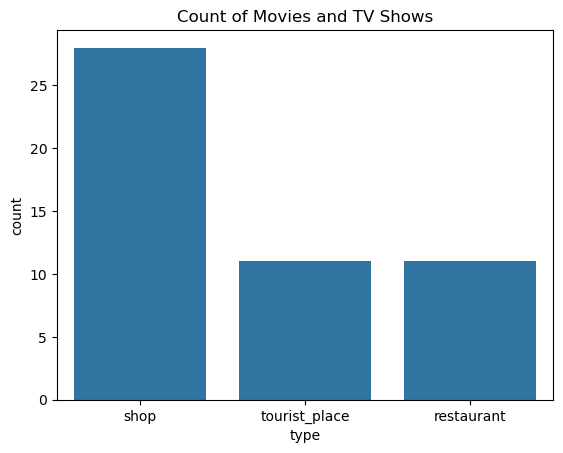

In [ ]:
sns.countplot(x='type', data = df)
plt.title('Count of Movies and TV Shows')
plt.show()

In [ ]:
# plt.figure(figsize=(10, 5))
# df['country_name'].value_counts().head(1000).plot(kind='bar')
# plt.title('Top 10 Countries with Most famous  tourist places ')
# plt.xlabel('country_name')
# plt.ylabel('city_name')
# plt.show()

In [ ]:

df = pd.read_parquet('cleaned_places.parquet')
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
batch_size = 100
embeddings = []
for i in range(0, len(df), batch_size):
    batch = df['full_desc_en'].iloc[i:i+batch_size].tolist()
    batch_emb = model.encode(batch, show_progress_bar=True)
    embeddings.extend(batch_emb)

embed_df = pd.DataFrame(embeddings, columns=[f'emb_{j}' for j in range(len(embeddings[0]))])
encoder = OneHotEncoder(sparse_output=False)
cat_features = encoder.fit_transform(df[['type', 'city_name']])
cat_df = pd.DataFrame(cat_features, columns=encoder.get_feature_names_out())
def haversine_distance(lat1, lon1, lat2, lon2):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371  
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

ref_lat, ref_lon = 41.3275, 19.8187  
df['distance_km'] = df.apply(lambda row: haversine_distance(ref_lat, ref_lon, row['latitude'], row['longitude']), axis=1)
features = pd.concat([embed_df, cat_df, df[['distance_km']]], axis=1)
features.to_parquet('features_for_model.parquet', index=False)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.head(10)

,city_id,location,latitude,longitude,created_at,city_name,country_name,type,450,451,...,name_en,name_ar,name_sq,short_description_en,short_description_ar,short_description_sq,full_desc_en,full_desc_ar,full_desc_sq,distance_km
0,85.0,https://www.google.com/maps?q=Bakuriani%20Plaz...,41.748334,43.537605,2025-08-18T12:32:26.000000Z,Bakuriani,Georgia,shop,None,None,...,bakuriani plaza,باكورياني بلازا,bakuriani,discover a vibrant shopping haven at bakuriani...,اكتشف ملاذا للتسوق النابض بالحياة في bakuriani...,zbuloni një strehë të gjallë të blerjeve në ba...,trendy fashion boutique luxury home decor empo...,بوتيك أزياء عصري ديكور المنزل الفاخر emporium ...,boutique i modës në modë emporium dekor luksoz...,1968.444083
1,85.0,https://www.google.com/maps?q=Joyland%20Amusem...,41.747982,43.526606,2025-08-18T12:29:11.000000Z,Bakuriani,Georgia,shop,None,None,...,joyland amusement park,حديقة الملاهي joyland,parku argëtues joyland,experience thrilling fun at joyland amusement ...,عش متعة مثيرة في منتزه جويلاند الترفيهي مع الأ...,përjetoni argëtim emocionues në joyland amusem...,toy emporium offering unique souvenirs fashion...,لعبة emporium تقدم هدايا تذكارية فريدة ملاذ ال...,emporium lodër që ofron suvenire unike strehë ...,1967.542127
2,76.0,https://www.google.com/maps?q=Grand%20Mall&fti...,42.255749,42.673122,2025-08-18T00:12:32.000000Z,Gudauri,Georgia,shop,None,None,...,grand mall,جراند مول,qendër e madhe,experience a diverse shopping journey at grand...,تجربة رحلة تسوق متنوعة في جراند مول مع وسائل ا...,përjetoni një udhëtim të larmishëm për blerje ...,discover the vibrant shopping scene in kutaisi...,اكتشف مشهد التسوق النابض بالحياة في كوتايسي ج...,zbuloni skenën e gjallë të blerjeve në kutaisi...,1891.846533
3,76.0,https://www.google.com/maps?q=Hotel%20Tsiga%20...,42.476942,44.477436,2025-08-18T00:11:21.000000Z,Gudauri,Georgia,shop,None,None,...,hotel tsiga gudauri,فندق tsiga في جوداوري,hotel tsiga gudauri,hotel tsiga gudauri offers a vibrant shopping ...,يقدم فندق tsiga gudauri تجربة تسوق نابضة بالحي...,hotel tsiga gudauri ofron një përvojë të gjall...,discover unique finds at smart explore quality...,اكتشف اكتشافات فريدة في smart استكشف معدات الج...,zbuloni gjetjet unike në smart eksploroni vesh...,2037.581527
4,76.0,https://www.google.com/maps?q=Sports%20%26%20S...,42.470401,44.485118,2025-08-18T00:09:20.000000Z,Gudauri,Georgia,shop,None,None,...,sports ski georgia,الرياضة والتزلج جورجيا,gjeorgji sport ski,experience premium ski gear and exceptional se...,تجربة معدات التزلج المتميزة والخدمة الاستثنائي...,përjetoni veshje premium skive dhe shërbim të ...,discover the ultimate ski rental service in gu...,اكتشف خدمة تأجير التزلج النهائية في جودوري جو...,zbuloni shërbimin përfundimtar të qirave të sk...,2038.270120
5,76.0,https://www.google.com/maps?q=Go%20Gudauri%20S...,42.472000,44.493834,2025-08-18T00:07:33.000000Z,Gudauri,Georgia,shop,None,None,...,go gudauri spa,اذهب إلى سبا,shko gudauri spa,indulge in luxury at go gudauri spa offering a...,تنغمس في الرفاهية في go gudauri spa مما يوفر ...,kënaquni me luksin në go gudauri spa duke ofru...,experience the ultimate shopping retreat in gu...,جرب تراجع التسوق النهائي في جودوري جورجيا مل...,përjetoni tërheqjen përfundimtare të blerjeve ...,2038.967566
6,76.0,https://www.google.com/maps?q=Tsar%20Bani&ftid...,42.469574,44.482697,2025-08-18T00:05:51.000000Z,Gudauri,Georgia,shop,None,None,...,tsar bani,القيصر باني,tsar bani,experience a vibrant shopping haven at tsar ba...,تجربة ملاذ تسوق نابض بالحياة في القيصر باني ح...,përjetoni një strehë të gjallë të blerjeve në ...,explore the bustling city of gudauri georgias ...,استكشف مدينة جودوري الصاخبة جوهرة التسوق في ج...,eksploroni qytetin e gjallë të gudauri gem geo...,2038.079857
7,76.0,https://www.google.com/maps?q=Mall%20of%20Geor...,34.065141,-83.984484,2025-08-18T00:04:38.000000Z,Gudauri,Georgia,shop,None,None,...,mall of georgia,مول جورجيا,qendra e gjeorgjisë,shopping destination with a stately feel landm...,وجهة تسوق تتميز بأجواء فخمة م

In [ ]:
import pandas as pd
import numpy as np

# Load features
features_df = pd.read_parquet('features_for_model.parquet')
print(features_df.shape)  # Should be (1084, 512 + num_types + num_cities + 1)

# Item IDs (use index or a unique identifier from original data)
item_ids = df.index  # Assuming df from cleaned_places.parquet

(1128, 524)
